In [1]:
from PIL import Image
import numpy as np
import random
import time

In [2]:
# Colors are dark and bright
WARRIOR_COLORS = (((30,30,30), (200,200,200)),
                  ((0,0,100), (0,0,255)),
                  ((0,100,0), (0,255,0)),
                  ((100,0,0), (255,0,0)),
                  ((0,100,100), (0,255,255)),
                  ((100,0,100), (255,0,255)),
                  ((66,66,100), (170,170,255)),
                  ((100,66,66), (255,170,170)),
                  ((66,100,66), (170,255,170)),
                  ((100,100,0), (255,255,0)),
                  ((0,0,100), (0,0,255)),
                  ((0,100,0), (0,255,0)),
                  ((100,0,0), (255,0,0)),
                  ((0,100,100), (0,255,255)),
                  ((100,0,100), (255,0,255)),
                  ((66,66,100), (170,170,255)),
                  ((100,66,66), (255,170,170)),
                  ((66,100,66), (170,255,170)),
                  ((100,100,0), (255,255,0)))

WARRIOR_COLORS = (((200,200,200), (200,200,200)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((10,10,10), (0,0,255)),
                  ((100,100,0), (255,255,0)))

wc_arr = np.array(WARRIOR_COLORS, dtype=np.uint8)

# specify the image size
shape = (125, 64)

In [3]:
# read change rate, write change rate, consumption
rcr = 0.3
wcr = 0.7
ccr = 1.0
# memory unit pixel size
ps = 7
pad = 2
ps2 = ps**2

In [4]:
# reading the initial frame
i = 0
init_record = np.load("../games/test_"+str(i)+".npz")["record"]
# reshaping to the image size
rs_init_record = init_record.reshape((shape[0], shape[1], 6))
# coloring based on the writer warrior
# reader warrior index: 4
# writer warrior index: 5
img = Image.fromarray(wc_arr[rs_init_record[:, :, 5], 0])
# increasing the image resolution
img = img.resize((shape[1]*ps, shape[0]*ps), resample=Image.NEAREST)
img_arr = np.pad(np.array(img), ((pad, pad), (pad, pad), (0,0)), mode='constant', constant_values=[0])

In [5]:
img_arr.shape

(879, 452, 3)

In [6]:
def spray_read(img_arr, record, pre_record, shape, ps, pad, rcr, wc_arr):
    # read the new record
    record = np.load("../games/test_"+str(i)+".npz")["record"]
    
    # find the recent reads by agents
    recent_read = np.argwhere(record[:, 4] != pre_record[:, 4]).flatten()
    # extract the x, y indices
    x_ri, y_ri = np.unravel_index(recent_read, shape)

    # generate the read spray kernels (randomly)
    read_spray_kernel = np.random.rand(recent_read.size, ps + 2*pad, ps + 2 * pad)
    # convert spray to indices
    rsk_index = np.argwhere(read_spray_kernel < rcr)

    
    # Right Side: reads the first element of rsk_index which is the id of the read change in this iteration, and with that index we read the id of the memory unit that has been changed from the recent_read, and with the memory unit id and 4 (read) we read the id of the agent that has executed the read, and we use this agent id to extract the color of the agent from wc_arr

    # Left Side: reads the first element of rsk_index which is the id of the read change in this iteration, and with that we read the x index that corresponds to the memory unit and multiply it with the pixel scale to find the top-left corner of the representing area in the high-resolution image, then we add the rsk_index column 1 to find the randomly selected pixel in the area that we need to change its color
    # print((x_ri[rsk_index[:, 0]] * ps + rsk_index[:, 1]).shape, (y_ri[rsk_index[:, 0]] * ps + rsk_index[:, 2]).shape)
    # print(img_arr[x_ri[rsk_index[:, 0]] * ps + rsk_index[:, 1], y_ri[rsk_index[:, 0]] * ps + rsk_index[:, 2]])
    img_arr[x_ri[rsk_index[:, 0]] * ps + rsk_index[:, 1], y_ri[rsk_index[:, 0]] * ps + rsk_index[:, 2]] += wc_arr[record[recent_read[rsk_index[:, 0]], 4], 0]

    return img_arr


def spray_write(img_arr, record, pre_record, shape, ps, pad, wcr, wc_arr):
    # find the recent reads by agents
    recent_write = np.argwhere(record[:, 5] != pre_record[:, 5]).flatten()
    # extract the x, y indices
    x_wi, y_wi = np.unravel_index(recent_write, shape)

    # generate the read spray kernels (randomly)
    write_spray_kernel = np.random.rand(recent_write.size, ps, ps)
    # convert spray to indices
    wsk_index = np.argwhere(write_spray_kernel < wcr)

    img_arr[x_wi[wsk_index[:, 0]] * ps + wsk_index[:, 1], y_wi[wsk_index[:, 0]] * ps + wsk_index[:, 2]] -= wc_arr[record[recent_write[wsk_index[:, 0]], 4], 0]
    
    return img_arr

def spray_consumption(img_arr, record, pre_record, shape, ps, pad, ccr, wc_arr):
    # consumption condition are threefold:
    # 1. an action of read has executed at this memory unit
    # 2. the agent responsible for the read action is different from the agent that has lastly written in the same unit
    # 3. the agent responsible for the last write action is not 0 (which is the initialization action)
    recent_consumption = np.argwhere((record[:, 4] != pre_record[:, 4]) * (record[:, 4] != record[:, 5])* (record[:, 4] != 0)).flatten()
    # extract the x, y indices
    x_wi, y_wi = np.unravel_index(recent_consumption, shape)

    # generate the consumption spray kernels (randomly)
    consumption_spray_kernel = np.random.rand(recent_consumption.size, ps, ps)
    # convert spray to indices
    csk_index = np.argwhere(consumption_spray_kernel < ccr)

    img_arr[x_wi[csk_index[:, 0]] * ps + csk_index[:, 1], y_wi[csk_index[:, 0]] * ps + csk_index[:, 2]] = np.array([255, 0, 0])
    
    return img_arr


In [9]:
# initialize the prerecord
pre_record = init_record

# iterate over frames
for i in range(1, 13700):
    # read the new record
    record = np.load("../games/test_"+str(i)+".npz")["record"]
    
    # # spray the read actions
    # img_arr = spray_read(img_arr, record, pre_record, shape, ps, pad, rcr, wc_arr)

    # # spray the write actions
    # img_arr = spray_write(img_arr, record, pre_record, shape, ps, pad, wcr, wc_arr)
    
    # spray the consumption
    img_arr = spray_consumption(img_arr, record, pre_record, shape, ps, pad, ccr, wc_arr)

    # update the prerecord
    pre_record = record



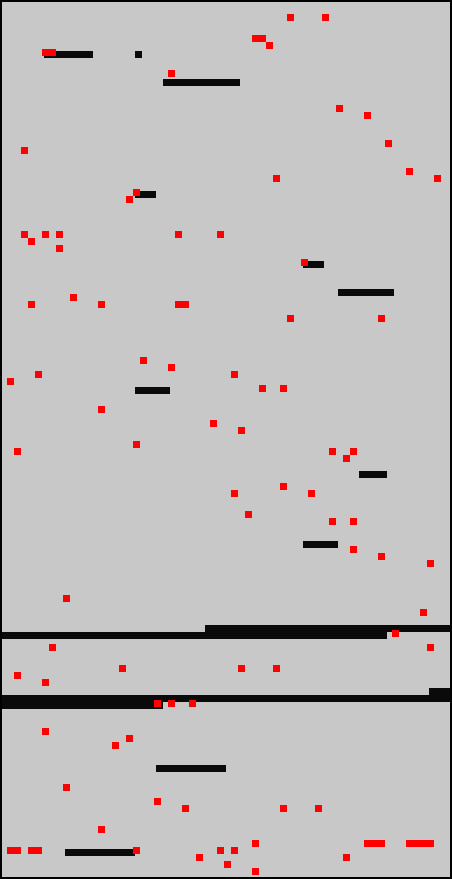

In [10]:
new_img = Image.fromarray(img_arr)
new_img.save("../out/I2/I2_" + str(time.time()) + ".png")
new_img

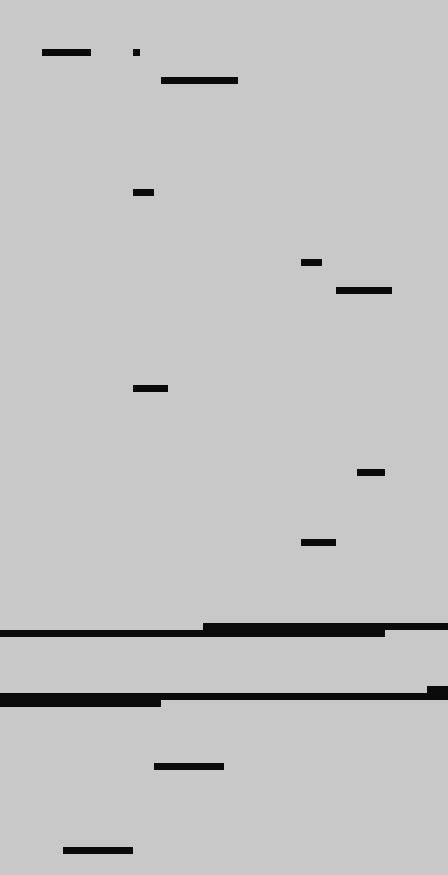

In [9]:
img

In [34]:
img.save("../out/I2/I2_" + str(time.time()) + ".png")